In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

Using TensorFlow backend.


In [2]:
mnist = input_data.read_data_sets("MNIST_data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
X_m = mnist.train.images
y = mnist.train.labels

# AutoEncoding LLE

## LLE

In [4]:
from sklearn.neighbors import NearestNeighbors 
from sklearn import datasets, neighbors
import numpy as np

def Knbor_Mat(X, K,  dist_metric = "euclidean", algorithm = "ball_tree"):
    
    n,p = X.shape
    
    knn = neighbors.NearestNeighbors(K+1, metric = dist_metric, algorithm=algorithm).fit(X)
    distances, nbors = knn.kneighbors(X)
    
    return(nbors[:,1:])

In [5]:
# calculation of reconstruction weights
from scipy import linalg

def get_weights(X, nbors, reg, K):
    
    n,p = X.shape
    
    Weights = np.zeros((n,n))
    
    for i in range(n):
        
        X_bors = X[nbors[i],:] - X[i]
        cov_nbors = np.dot(X_bors, X_bors.T)
        
        #regularization tems
        trace = np.trace(cov_nbors)
        if trace >0 :
            R = reg*trace
        else:
            R = reg
        
        cov_nbors.flat[::K+1] += R
        weights = linalg.solve(cov_nbors, np.ones(K).T, sym_pos=True)

        weights = weights/weights.sum()
        Weights[i, nbors[i]] = weights
        
    return(Weights)

In [ ]:
class LLE:
    def __init__(self,X,K):
        self.K = K
        self.X = X
        
    def Knbor_Mat(dist_metric = "euclidean", algorithm = "ball_tree"):
        
        knn = neighbors.NearestNeighbors(self.K+1, metric = dist_metric, algorithm=algorithm).fit(X)
        distances, nbors = knn.kneighbors(X)
        return(nbors[:,1:])
    def get_weights(reg):
        
        nbors = self.Knbor_Mat()
        n,_ = self.X.shape
        Weights = np.zeros((n,n))
        for i in range(n):

            X_bors = X[nbors[i],:] - X[i]
            cov_nbors = np.dot(X_bors, X_bors.T)
            #regularization tems
            trace = np.trace(cov_nbors)
            if trace >0 :
                R = reg*trace
            else:
                R = reg
            cov_nbors.flat[::K+1] += R
            weights = linalg.solve(cov_nbors, np.ones(K).T, sym_pos=True)
            weights = weights/weights.sum()
            Weights[i, nbors[i]] = weights

        return(Weights)
    
        

## DAE

### Initialisation Of the hyper params 


In order to implement our algorithm combining DAE and LLE we will first initialize the hyper params 

In [6]:
Learning_rate = 0.01
Lr_Epochs = 200
BATCH_SIZE = 256
NUM_BATCHES = int(mnist.train.num_examples/BATCH_SIZE)


Hidden_size_1 = 256
Hidden_size_2 = 128
Input_size = 784

Lambda_reg_rate = 0.01

Print_freq = 1
display = 10



### Conception of the DAE Architecture

Now we can build the deep autoencoding architecture 

We will have in this arcitecture a 4 layers Neural network including 2 encoding layer (Encoder) and 2 decoding layers (Decoder)

In [7]:
X = tf.placeholder("float", [None, Input_size])

#### LLE S Matrice Holder

we will include LLE to our learning step and in order to do so we create a placeholder for the S matrice

In [8]:
S = tf.placeholder(tf.float32,[None, None])

#### Weights Matrices

In [9]:
Hidden_weights = {
'encodeur_h1': tf.Variable(tf.random_normal([Input_size, Hidden_size_1])),
'encodeur_h2': tf.Variable(tf.random_normal([Hidden_size_1, Hidden_size_2])),
'decodeur_h1': tf.Variable(tf.random_normal([Hidden_size_2, Hidden_size_1])),
'decodeur_h2': tf.Variable(tf.random_normal([Hidden_size_1, Input_size])),
}

#### Biais Matrices  

In [10]:
biais = {
'encodeur_b1': tf.Variable(tf.random_normal([Hidden_size_1])),
'encodeur_b2': tf.Variable(tf.random_normal([Hidden_size_2])),
'decodeur_b1': tf.Variable(tf.random_normal([Hidden_size_1])),
'decodeur_b2': tf.Variable(tf.random_normal([Input_size])),
}

#### First layer encodeur_in = (W*x + b)

In [11]:
encodeur_in = tf.nn.sigmoid(tf.add(tf.matmul(X,Hidden_weights['encodeur_h1']),biais['encodeur_b1']))

#### Second layer encodeur_out = (W * encodeur_in + b)

In [12]:
encodeur_out = tf.nn.sigmoid(tf.add(tf.matmul(encodeur_in,Hidden_weights['encodeur_h2']),biais['encodeur_b2']))

#### First decoding layer decodeur_in = (W*encodeur_out + b)

In [13]:
decodeur_in = tf.nn.sigmoid(tf.add(tf.matmul(encodeur_out,Hidden_weights['decodeur_h1']),biais['decodeur_b1']))

#### Second decoding layer decodeur_out = (W*decodeur_in + b)

In [14]:
decodeur_out = tf.nn.sigmoid(tf.add (tf.matmul(decodeur_in,Hidden_weights['decodeur_h2']),biais['decodeur_b2']))

In [15]:
X_reconst = decodeur_out
X_originale = X

### Loss Function 
Now we define the loss function to be optimized 

#### Learning loss function

In [18]:
Train_loss_func = tf.reduce_mean(tf.pow(X_originale - X_reconst, 2)) + Lambda_reg_rate * tf.reduce_mean(tf.pow(encodeur_out - tf.matmul(S,encodeur_out), 2))

#### Test Loss function 

In [19]:
Test_loss_func = tf.reduce_mean(tf.pow(X_originale- X_reconst, 2))

#### Optimizer ( RMSProp )

In [20]:
optimisation = tf.train.RMSPropOptimizer(Learning_rate).minimize(Train_loss_func)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Learning step

In [21]:
initialisation = tf.global_variables_initializer()
Learning_losses, Test_losses = [],  []
Iter_weights = []

In [ ]:
with tf.Session() as sess:
    sess.run(initialisation)
    NUM_BATCHES = int(mnist.train.num_examples/BATCH_SIZE)
    for Epoch in range(Lr_Epochs):
        for i in range(NUM_BATCHES):
            
            
            batch_xs, _ = mnist.train.next_batch(BATCH_SIZE)
            sortie = sess.run(encodeur_out, feed_dict={X: batch_xs})
            
            
            lle = LLE(sortie,10)
            
            W = lle.get_weights(sortie, 0.01, 10)
            
            
            
            _, tr_loss = sess.run([optimisation, Train_loss_func],feed_dict={X: batch_xs, S: W})
            
            batch_x_test_s, _ = mnist.test.next_batch(BATCH_SIZE)
            #X_reconst = sess.run(X_reconst, feed_dict={X: mnist.test.images[:BATCH_SIZE]})
            
            tst_loss = sess.run([Test_loss_func],feed_dict={X_originale: batch_x_test_s})[0]
            

            
            
            
        if Epoch % Print_freq == 0:
            Learning_losses.append(tr_loss)
            Test_losses.append(tst_loss)
            Iter_weights.append(W)


            print("Epoch:", '%04d' % (Epoch+1),
                      "Train Loss=", "{:.9f}".format(tr_loss), "Test loss=", "{:.9f}".format(tst_loss))

    print("Done!")
    encode_out = sess.run(encodeur_out, feed_dict={X:X_m})
    encode_decode = sess.run(X_reconst, feed_dict={X: mnist.test.images[:display]})
    encode_decode_total = sess.run(X_reconst, feed_dict={X: mnist.test.images[:]})

Epoch: 0001 Train Loss= 0.222293019 Test loss= 0.224014714
Epoch: 0002 Train Loss= 0.195469514 Test loss= 0.194564238
Epoch: 0003 Train Loss= 0.173109084 Test loss= 0.173457667
Epoch: 0004 Train Loss= 0.165362984 Test loss= 0.162769526
Epoch: 0005 Train Loss= 0.158540606 Test loss= 0.160114139
Epoch: 0006 Train Loss= 0.154263645 Test loss= 0.153383330
Epoch: 0007 Train Loss= 0.145220801 Test loss= 0.146027043
Epoch: 0008 Train Loss= 0.144089416 Test loss= 0.143496946
Epoch: 0009 Train Loss= 0.141895697 Test loss= 0.141435027
Epoch: 0010 Train Loss= 0.140672624 Test loss= 0.140734807
Epoch: 0011 Train Loss= 0.137292489 Test loss= 0.137174487
Epoch: 0012 Train Loss= 0.134278774 Test loss= 0.133783415
Epoch: 0013 Train Loss= 0.130869776 Test loss= 0.130228400
Epoch: 0014 Train Loss= 0.128194883 Test loss= 0.128373221
Epoch: 0015 Train Loss= 0.127520651 Test loss= 0.126702741
Epoch: 0016 Train Loss= 0.123222932 Test loss= 0.123509511
Epoch: 0017 Train Loss= 0.121614106 Test loss= 0.1221516

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(Learning_losses, label="Learning Loss", color='darkorange')
plt.plot(Test_losses, label="Testing Loss", color='blue')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Loss on Training Phase")
plt.legend()
plt.show()

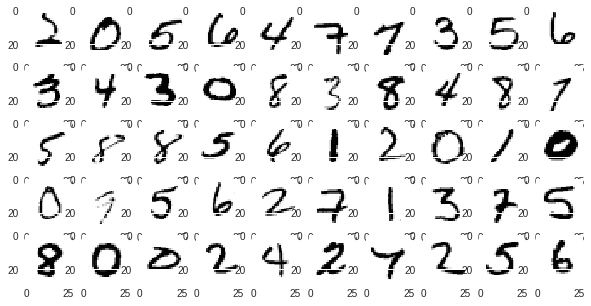

In [560]:
f, a = plt.subplots(5, display, figsize=(display, 5))
for i in range(display):
    
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(mnist.test.images[i+10], (28, 28)))
    a[2][i].imshow(np.reshape(mnist.test.images[i+20], (28, 28)))
    a[3][i].imshow(np.reshape(mnist.test.images[i+30], (28, 28)))
    a[4][i].imshow(np.reshape(mnist.test.images[i+40], (28, 28)))
    f.show()
plt.draw()
plt.show()

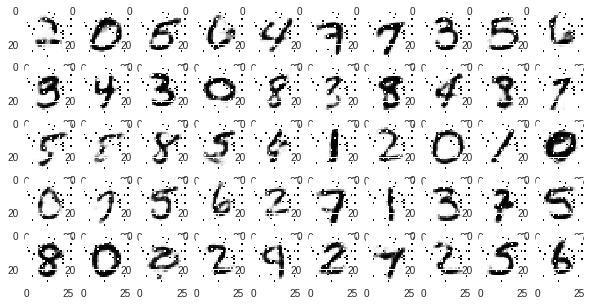

In [559]:
f, a = plt.subplots(5, display, figsize=(display, 5))
for i in range(display):
    a[0][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i+10], (28, 28)))
    a[2][i].imshow(np.reshape(encode_decode[i+20], (28, 28)))
    a[3][i].imshow(np.reshape(encode_decode[i+30], (28, 28)))
    a[4][i].imshow(np.reshape(encode_decode[i+40], (28, 28)))
    f.show()
plt.draw()
plt.show()

In [506]:
len(Learning_losses)

200

In [507]:
len(Test_losses)

200

In [509]:
Iter_weights

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.13835356,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
       

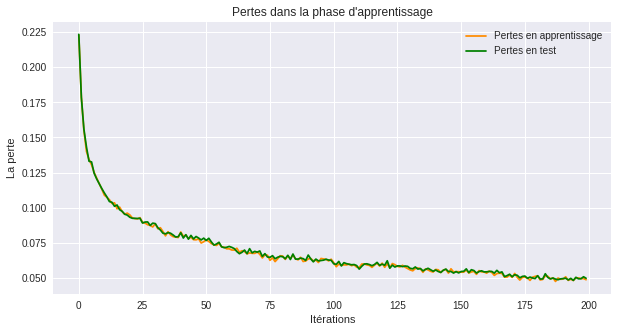